<a href="https://colab.research.google.com/github/ray-hu/EM-Segmentation/blob/master/SegNet_EM_aug_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

### **Install Pytorch**

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/cu80/torch-0.2.0.post2-cp36-cp36m-manylinux1_x86_64.whl torchvision # http://download.pytorch.org/whl/{accelerator}/torch-0.2.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.2.0_2
True


### **Upgrading Tensorflow**

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow

# For the latest nightly build:
#!pip install tf-nightly

Name: tensorflow
Version: 1.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, six, numpy, grpcio, keras-preprocessing, gast, wheel, keras-applications, termcolor, tensorboard, protobuf, astor
Required-by: 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.12.0)


### **Import Keras**

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [0]:
!pip install Keras

In [0]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.2.4


### **Import other libraries**

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image
# Restart then PIL will have no error

    100% |████████████████████████████████| 5.6MB 4.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 5.3MB/s 


### Upload dataset to your google drive
./My\ Drive/data

### **Mounting Google Drive locally**

In [0]:
from google.colab import drive
drive.mount('./GoogleDrive')

Drive already mounted at ./GoogleDrive; to attempt to forcibly remount, call drive.mount("./GoogleDrive", force_remount=True).


In [0]:
#!rm drive

In [0]:
! ln -s GoogleDrive/My\ Drive ./drive

In [0]:
! ls

In [0]:
#! ls drive/EM/train-volume.tif

# **Data Augmentation**

In [0]:
import os
import glob
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img

In [0]:
train_imgs_path = glob.glob("drive/data/train"+"/*."+"tif")
label_imgs_path = glob.glob("drive/data/label"+"/*."+"tif")
test_imgs_path = glob.glob("drive/data/test"+"/*."+"tif")

print("We have {} training images in total.".format(len(train_imgs_path)))
print("We have {} training labels in total.".format(len(label_imgs_path)))
print("We have {} testing images in total.".format(len(test_imgs_path)))
if len(train_imgs_path) != len(label_imgs_path) or len(train_imgs_path) == 0:
        print ("num of trains can't match num of labels")

We have 30 training images in total.
We have 30 training labels in total.
We have 30 testing images in total.


Showing the orginal data:


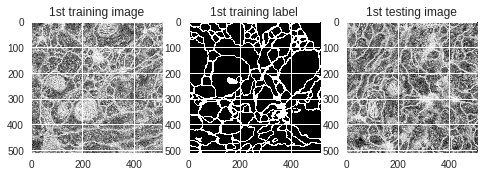

In [0]:
# show the original images
print('Showing the orginal data:')
from skimage import io
image_train = io.imread(train_imgs_path[0])
label_train = io.imread(label_imgs_path[0])
image_test = io.imread(test_imgs_path[0])
f, ax = plt.subplots(1,3)
ax[0].imshow(image_train)
ax[0].set_title('1st training image')
ax[1].imshow(label_train)
ax[1].set_title('1st training label')
ax[2].imshow(image_test)
ax[2].set_title('1st testing image')
plt.show()

In [0]:
# creat folder for the augmentation
path_aug = "drive/data/aug"
if not os.path.lexists(path_aug):
  os.mkdir(path_aug)
savedir = path_aug + "/train"
if not os.path.lexists(savedir):
  os.mkdir(savedir)
savedir = path_aug + "/label"
if not os.path.lexists(savedir):
  os.mkdir(savedir)

In [0]:

def data_augmentation(path_aug='drive/data/aug'):
    
	#read images
    train_path="drive/data/train"
    label_path="drive/data/label"
    img_type="tif"
    train_imgs = glob.glob(train_path+"/*."+img_type)
    label_imgs = glob.glob(label_path+"/*."+img_type)
    slices = len(train_imgs)
    
   # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(rotation_range=10,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0)
	# merge label and train
    print('Using real-time data augmentation.')
    #one by one augmentation
    for i in range(slices):
        img_t = load_img(train_path+"/"+str(i)+".tif",grayscale=True)
        img_l = load_img(label_path+"/"+str(i)+".tif",grayscale=True)
        x_t = img_to_array(img_t)
        x_l = img_to_array(img_l)
        s=np.shape(x_t)
        img = np.ndarray(shape=(s[0],s[1],3),dtype=np.uint8)
      
        img[:,:,0]=x_t[:,:,0]
        img[:,:,2]=x_l[:,:,0]
        	# here's a more "manual" example
        img = img.reshape((1,) + img.shape)
        batches = 0
        for batch in datagen.flow(img, batch_size=1,save_to_dir=path_aug,save_prefix=str(i),save_format='tif'):
            batches += 1
            if batches >= 30:
                break
            # we need to break the loop by hand because
            # the generator loops indefinitely
    aug_imgs = glob.glob(path_aug+"/*.tif")
    savedir = path_aug + "/train"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    savedir = path_aug + "/label"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    i=0
    for imgname in aug_imgs:
        img =load_img(imgname)
        img=img_to_array(img)
       
        img_train = img[:,:,:1]
        img_label = img[:,:,2:]
        img_train = array_to_img(img_train)
        img_label = array_to_img(img_label)
        img_train.save(path_aug+"/train/"+str(i)+".tif")
        img_label.save(path_aug+"/label/"+str(i)+".tif")
        i+=1

In [0]:
data_augmentation()

Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
train(imgs_train, imgs_mask_train, batch_size=4, n_epoch=10)

got unet
Fitting model...
Epoch 1/10


In [0]:
def testing(imgs_test):
	print('predict test data')
	imgs_mask_test = model.predict(imgs_test, batch_size=4, verbose=1)
	np.save(self.save_path+ "imgs_mask_test.npy", imgs_mask_test)
	print("array to image")
	imgs = np.load(self.save_path+"imgs_mask_test.npy")
	print(imgs.shape[0])
	for i in range(imgs.shape[0]):
		img = imgs[i]
		img[img > 0.5] = 1
		img[img<= 0.5] = 0
		img = array_to_img(img)
		img.save("./results/seg/"+ str(i)+".tif")

# **Build a Seg-net**

In [0]:
import torch
from torch import nn
from torchvision import models

from ..utils import initialize_weights
from .config import vgg19_bn_path


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(_DecoderBlock, self).__init__()
        middle_channels = in_channels / 2
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)


class SegNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SegNet, self).__init__()
        vgg = models.vgg19_bn()
        if pretrained:
            vgg.load_state_dict(torch.load(vgg19_bn_path))
        features = list(vgg.features.children())
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:27])
        self.enc4 = nn.Sequential(*features[27:40])
        self.enc5 = nn.Sequential(*features[40:])

        self.dec5 = nn.Sequential(
            *([nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)] +
              [nn.Conv2d(512, 512, kernel_size=3, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(inplace=True)] * 4)
        )
        self.dec4 = _DecoderBlock(1024, 256, 4)
        self.dec3 = _DecoderBlock(512, 128, 4)
        self.dec2 = _DecoderBlock(256, 64, 2)
        self.dec1 = _DecoderBlock(128, num_classes, 2)
        initialize_weights(self.dec5, self.dec4, self.dec3, self.dec2, self.dec1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        dec5 = self.dec5(enc5)
        dec4 = self.dec4(torch.cat([enc4, dec5], 1))
        dec3 = self.dec3(torch.cat([enc3, dec4], 1))
        dec2 = self.dec2(torch.cat([enc2, dec3], 1))
        dec1 = self.dec1(torch.cat([enc1, dec2], 1))
        return dec1


ValueError: ignored

# Training

### Load data

In [0]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

image_train =  io.imread_collection('drive/data/aug/train/*.tif').concatenate()
label_train = io.imread_collection('drive/data/aug/label/*.tif').concatenate()

imgs_train = image_train[:,np.newaxis,...]
groundTruth_train = label_train[:,np.newaxis,...]

ValueError: ignored

check the consistency of training data...
shape of imgs_train: (1794, 1, 512, 512)
shape of groundTruth_train (1794, 1, 512, 512)
check the first augmented image and its label...


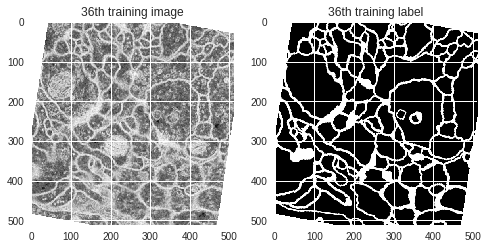

In [0]:
print("check the consistency of training data...")
print("shape of imgs_train: {}".format(imgs_train.shape))
print('shape of groundTruth_train {}'.format(groundTruth_train.shape))
print('check the first augmented image and its label...')
f, ax = plt.subplots(1,2)
ax[0].imshow(imgs_train[36].reshape((512,512)))
ax[0].set_title('36th training image')
ax[1].imshow(groundTruth_train[36].reshape((512,512)))
ax[1].set_title('36th training label')
plt.show()

### Train U-net

In [0]:
import time
import numpy as np
from random import shuffle  
import random


def sampling_data_aug(imgs_train, label_train):
  # split for training and validation
  imgs_train = imgs_train/255.
  label_train = label_train/255.
  dataset_train = [(img, mask) for img, mask in zip(imgs_train, label_train)]
  shuffle(dataset_train)
  dataset_train_split = dataset_train[0:int(len(dataset_train)*0.8)]
  dataset_valid_split = dataset_train[int(len(dataset_train)*0.8):]
  return dataset_train_split, dataset_valid_split

def training_batch_generator(dataset,batch_size=4):
  # generate batches
  shuffle(dataset)
  N_full_batches = int(np.ceil(len(dataset) / batch_size))
  for i in range(N_full_batches):
    idx_from = batch_size * i
    idx_to = batch_size * (i + 1)
    if idx_to>len(dataset):
      idx_to=len(dataset)
    imgs, masks = zip(*[(img, mask) for img, mask in dataset[idx_from:idx_to]])
    yield imgs, masks
        
def train(net, imgs_train, label_train, n_epoch=10, batch_size=4):

  optimizer = optim.Adam(net.parameters(), lr=1e-4, 
                         betas=(0.9, 0.999), eps=1e-05)
  criterion = nn.BCELoss()
  img_size = 512 ###############
  for epoch in range(n_epoch):
    begin = time.time()
    total_loss_train = 0
    dataset_train_split, dataset_valid_split= sampling_data_aug(imgs_train, label_train)
    bgen = training_batch_generator(dataset_train_split, batch_size=batch_size)
    net.train()
    for idx, (imgs, masks) in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
      masks = np.asarray(masks).reshape(len(masks), 1, img_size, img_size)
      # print(imgs.shape)
      inputs = Variable(torch.from_numpy(imgs).type(dtype))
      targets = Variable(torch.from_numpy(masks).type(dtype))

      optimizer.zero_grad()
      pred = net(inputs)

      loss = criterion(pred, targets)
      loss.backward()

      optimizer.step()

      current_loss = loss.data[0]
      total_loss_train += current_loss
  print('epoch {} -- training loss {}'.format(epoch, total_loss_train/len(dataset_train_split)))
  print('--------------------')
  torch.save(net.state_dict(), 'drive/data/u-net-em-1/params-{}-{}.pkl'.format(epoch, total_loss_train))
  print("Checkpoint saved")
  print('---------------------------------------------')

In [0]:
! mkdir drive/data/u-net-em-1

mkdir: cannot create directory ‘drive/data/u-net-em-1’: File exists


In [0]:
net = Unet()
train(net, imgs_train, groundTruth_train, n_epoch=1, batch_size=1)

# Test

### Load test data and trained model

In [0]:
import numpy as np
from skimage import io
from skimage import data_dir

image_test = io.imread_collection('drive/data/test/*.tif').concatenate()

imgs_test = image_test[:,np.newaxis,...]/225.

In [0]:
! ls drive/data/u-net-em-1

In [0]:
net = Unet()
net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-13-3.782213229686022.pkl'))

In [0]:
def test(net, imgs):
  net.eval()
  img_size = 512
  imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
  pred = net(imgs)
  return pred
    

In [0]:
pred.shape

(30, 1, 512, 512)

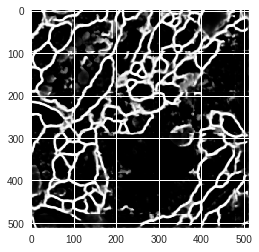

In [0]:
plt.imshow(pred[0][0])

In [0]:
results = np.squeeze(pred)
results = results.astype(np.float16)
io.imsave('drive/data/results.tif', results)

In [0]:
results = results.astype(np.float16)

In [0]:
io.imsave('drive/data/results.tif', results)